### Load the Libraries

In [6]:
import pandas as pd
import numpy as np
import os
import re
import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scikitplot as skplt

from tqdm.notebook import tqdm_notebook
from tqdm.notebook import tqdm
tqdm_notebook.pandas()

In [2]:
from pandas.errors import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

### Load the Summary dataset

In [ ]:
# Load file with user summaries
filename = os.path.join(os.path.dirname(__name__), "RawDataFiles/film_plots.tsv")
df = pd.read_csv(filename,delimiter='\t',low_memory=False)

# exclude all null values
df['summary'] = np.where(df['summary'].isnull(), 'None', df['summary'])
df = df[df['summary'] != 'None']

#### Explore word length of summaries

In [5]:
def word_count(x):
    x_list = x.split()
    return len(x_list)

df['summary_len'] = df['summary'].progress_apply(lambda x: word_count(x))
print("maximum length: ", max(df['summary_len']))
print("minimum length: ", min(df['summary_len']))
print("average length: ", np.average(df['summary_len']))

  0%|          | 0/8817 [00:00<?, ?it/s]

maximum length:  1023
minimum length:  3
average length:  68.74594533287967


largest length of a string: 1023


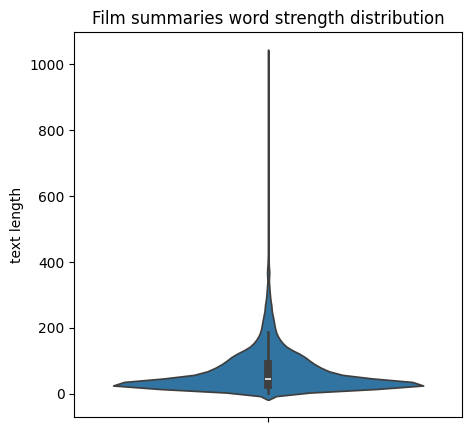

In [7]:
#check length
df = df.drop_duplicates()
df2 = df[df['summary'] != '']

length = [len(i.split()) for i in df2['summary']]
print('largest length of a string:', max(length))

plt.figure(figsize=(5,5))
sns.violinplot(y = length)
plt.ylabel('text length')
plt.title('Film summaries word strength distribution')
plt.show()

#### Data Cleaning
Keep Summaries with length greater than 5 and and less than equal to 500

In [8]:
df = df[df['summary_len']>5]
df = df[df['summary_len']<500]

In [9]:
df.head()

,summary,film_id,summary_id,summary_len
0,"Two detectives, a rookie and a veteran, hunt a...",tt0114369,1,20
1,A film about two homicide detectives' (Morgan ...,tt0114369,2,134
2,"Taking place in a nameless city, Se7en follows...",tt0114369,3,96
3,"Two police detectives - one, Somerset, about t...",tt0114369,4,75
4,"Two detectives, one about to leave and one ent...",tt0114369,5,44


### Create sentiment score feature

In [11]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lovke\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']  # 'compound' gives the overall sentiment score

In [13]:
df['sentiment_score'] = df['summary'].progress_apply(lambda x: get_sentiment_score(x))
df.head()

  0%|          | 0/8798 [00:00<?, ?it/s]

,summary,film_id,summary_id,summary_len,sentiment_score
0,"Two detectives, a rookie and a veteran, hunt a...",tt0114369,1,20,-0.8074
1,A film about two homicide detectives' (Morgan ...,tt0114369,2,134,-0.9455
2,"Taking place in a nameless city, Se7en follows...",tt0114369,3,96,-0.9280
3,"Two police detectives - one, Somerset, about t...",tt0114369,4,75,-0.9638
4,"Two detectives, one about to leave and one ent...",tt0114369,5,44,-0.9153


#### Create ST Embeddings feature

In [14]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel
from sentence_transformers import util
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F
import torch

In [15]:
# Initialize the MiniLM model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def extract_tokens_and_embed(text, first_n=96, last_n=288):
    # Tokenize the text
    tokens = tokenizer(text, return_tensors='pt', truncation=False, padding=False, add_special_tokens=True)

    if len(tokens) > 382:
        # Extract the first 128 tokens
        first_part = tokens[:first_n]
        
        # Extract the last 382 tokens
        last_part = tokens[-last_n:]
    
        # Concatenate the two parts
        combined_tokens = torch.cat([first_part, last_part])
    else:
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        # Generate Contextual embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            word_embeddings = outputs["last_hidden_state"][:,0,:]
            return word_embeddings
    
    #truncated_text = tokenizer.convert_tokens_to_string(combined_tokens)
    input_ids = torch.tensor(combined_tokens).unsqueeze(0)
    # Pass through the model to get embeddings
    with torch.no_grad():
        model_output = model(**input_ids)
        embedding = model_output["last_hidden_state"][:,0,:]
        #norm_embedding = F.normalize(embedding, p=2, dim=1)
        
    return embedding

h:\Kiran\anaconda3\envs\tf\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
df['st_embeddings'] = df['summary'].progress_apply(lambda x: extract_tokens_and_embed(x))
df.head()

  0%|          | 0/8798 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


,summary,film_id,summary_id,summary_len,sentiment_score,st_embeddings
0,"Two detectives, a rookie and a veteran, hunt a...",tt0114369,1,20,-0.8074,"[[tensor(-0.0401), tensor(0.0807), tensor(-0.2..."
1,A film about two homicide detectives' (Morgan ...,tt0114369,2,134,-0.9455,"[[tensor(-0.2029), tensor(-0.1971), tensor(-0...."
2,"Taking place in a nameless city, Se7en follows...",tt0114369,3,96,-0.9280,"[[tensor(0.0038), tensor(-0.0143), tensor(0.04..."
3,"Two police detectives - one, Somerset, about t...",tt0114369,4,75,-0.9638,"[[tensor(-0.2685), tensor(-0.1503), tensor(-0...."
4,"Two detectives, one about to leave and one ent...",tt0114369,5,44,-0.9153,"[[tensor(-0.1507), tensor(-0.0273), tensor(-0...."


#### Write to feature dataset file

In [ ]:
df.to_csv(os.path.join(os.path.dirname(__name__), "ProcessedDataFiles\\feature_dataset.tsv"), sep='\t', index=False)

### Create unlabelled dataset

In [19]:
df.head()

,summary,film_id,summary_id,summary_len,sentiment_score,st_embeddings
0,"Two detectives, a rookie and a veteran, hunt a...",tt0114369,1,20,-0.8074,"[[tensor(-0.0401), tensor(0.0807), tensor(-0.2..."
1,A film about two homicide detectives' (Morgan ...,tt0114369,2,134,-0.9455,"[[tensor(-0.2029), tensor(-0.1971), tensor(-0...."
2,"Taking place in a nameless city, Se7en follows...",tt0114369,3,96,-0.9280,"[[tensor(0.0038), tensor(-0.0143), tensor(0.04..."
3,"Two police detectives - one, Somerset, about t...",tt0114369,4,75,-0.9638,"[[tensor(-0.2685), tensor(-0.1503), tensor(-0...."
4,"Two detectives, one about to leave and one ent...",tt0114369,5,44,-0.9153,"[[tensor(-0.1507), tensor(-0.0273), tensor(-0...."


In [ ]:
# Load file with target labelled values
filename = os.path.join(os.path.dirname(__name__), "ProcessedDataFiles/target_labels.csv")
target_df = pd.read_csv(filename,delimiter=',',low_memory=False)

In [45]:
labelled_movie_list = list(target_df.film_id.unique())

In [46]:
single_summary_df = df[df['film_id'].isin(labelled_movie_list)]
single_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3476 entries, 0 to 12128
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   summary          3476 non-null   object 
 1   film_id          3476 non-null   object 
 2   summary_id       3476 non-null   int64  
 3   sentiment_score  3476 non-null   float64
 4   st_embeddings    3476 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 162.9+ KB


In [48]:
unlabelled_data = df[~df['film_id'].isin(labelled_movie_list)]

994